<a href="https://colab.research.google.com/github/RavenPillmann/foodgan/blob/master/FoodGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [0]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import storage


project_id = "recipe2image-244621"
import os
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id
client = storage.Client(project=project_id)
bucket = client.get_bucket('recipes-with-images')

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('./images.zip', 'r')
zip_ref.extractall("./images")
zip_ref.close()

In [0]:
def get_generator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''
  
  hid = Dense(128 * 32 * 32, activation='relu')(input_layer)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((32, 32, 128))(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=4, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

#   hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
#   hid = BatchNormalization(momentum=0.9)(hid)
#   #hid = Dropout(0.5)(hid)
#   hid = LeakyReLU(alpha=0.1)(hid)
  
  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  
#   hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
#   hid = BatchNormalization(momentum=0.9)(hid)
#   hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  
  
#   hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
#   hid = BatchNormalization(momentum=0.9)(hid)
#   hid = LeakyReLU(alpha=0.1)(hid)

#   hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
#   hid = BatchNormalization(momentum=0.9)(hid)
#   #hid = Dropout(0.5)(hid)
#   hid = LeakyReLU(alpha=0.1)(hid)

#   hid = Conv2D(64, kernel_size=5, strides=1, padding='same')(hid)
#   hid = BatchNormalization(momentum=0.9)(hid)
#   hid = LeakyReLU(alpha=0.1)(hid)
                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(input_layer, out)
  model.summary()
  
  return model, out

In [0]:
def get_discriminator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''

  hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  
#   hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
#   hid = BatchNormalization(momentum=0.9)(hid)
#   hid = LeakyReLU(alpha=0.1)(hid)
  
  hid = Flatten()(hid)
  hid = Dropout(0.4)(hid)
  out = Dense(69, activation='sigmoid')(hid)

  model = Model(input_layer, out)

  model.summary()

  return model, out

In [0]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def show_imgs(batchidx):
  noise = generate_noise(9, 100)
  input_class_section = np.ones((9, 19))
  ingreds = np.random.randint(0, 2, [9, 50])
  classes = np.random.randint(0, 19, 9)
  print("Classes", classes)
  for i in range(9):
    input_class_section[i, classes[i]] = 0
    
  input_class_section = np.hstack((input_class_section, ingreds))
  
  noise = np.hstack((noise, input_class_section))
  
  gen_imgs = generator.predict(noise)

  fig, axs = plt.subplots(3, 3)
  count = 0
  for i in range(3):
    for j in range(3):
      # Dont scale the images back, let keras handle it
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      count += 1
  plt.show()
  plt.close()

In [0]:
# GAN creation
img_input = Input(shape=(128, 128, 3))
discriminator, disc_out = get_discriminator(img_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='categorical_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(169,))
generator, gen_out = get_generator(noise_input)

gan_input = Input(shape=(169,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='categorical_crossentropy')

W0723 13:55:24.969257 140107080402816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 13:55:24.984706 140107080402816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 13:55:24.988671 140107080402816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 13:55:25.013918 140107080402816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0723 13:55:25.015091 1401070804

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 128)       0         
__________

In [0]:
# GAN LOADING
from keras.models import load_model

img_input = Input(shape=(128, 128, 3))
discriminator, disc_out = get_discriminator(img_input)
discriminator = load_model('all_ingredient_gan_disc_biggest_52.h5')
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='categorical_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(169,))
generator, gen_out = get_generator(noise_input)
generator = load_model('all_ingredient_gan_gen_biggest_52.h5')

gan_input = Input(shape=(169,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='categorical_crossentropy')

W0725 16:03:36.120483 140414929508224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 16:03:36.169294 140414929508224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 16:03:36.177793 140414929508224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 16:03:36.231727 140414929508224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0725 16:03:36.233385 1404149295

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 128)       0         
__________

W0725 16:03:40.980633 140414929508224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 16:03:41.115777 140414929508224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 169)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 131072)            22282240  
_________________________________________________________________
batch_normalization_6 (Batch (None, 131072)            524288    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 131072)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       409728    
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 128)       512       
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 169)               0         
_________________________________________________________________
model_2 (Model)              (None, 128, 128, 3)       24309635  
_________________________________________________________________
model_1 (Model)              (None, 69)                1620549   
Total params: 25,930,184
Trainable params: 24,046,467
Non-trainable params: 1,883,717
_________________________________________________________________


In [0]:
import cv2
def loadTrainingData(indices, batch_size):
	raw_imgs = []
	applicable_indices = []

# 	filepaths = ['./vegetable_images/vegetable_images/'+str(name)+'.jpg' for name in indices]
# 	filepaths = ['./noodle_pasta_augmented_images/noodle_pasta_augmented_images/'+str(name)+'.jpg' for name in indices]
	filepaths = ['./images/images/'+str(name)+'.jpg' for name in indices]
	names = [int(name) for name in indices]
  
	for i in range(len(filepaths)):
		filepath = filepaths[i]
		name = names[i]
		image = cv2.imread(filepath)

		if (not isinstance(image, type(None))):
			image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
			raw_imgs.append(image)
			applicable_indices.append(name)
		if len(raw_imgs) == batch_size:
			break

	img_tensors = [cv2.resize((raw_img - 127.5) / 127.5, (128, 128)) for raw_img in raw_imgs]

	return np.array(img_tensors), np.array(applicable_indices)

In [0]:
import csv
def loadAllTrainingY(filepath):
	y_train = {}

	with open(filepath, 'r') as input_file:
		csv_reader = csv.reader(input_file, delimiter=",")

		for row in csv_reader:
			_id = int(row[0])
			one_hot_encoded = row[1:]
			y_train[_id] = np.array(one_hot_encoded[:69])
      
	max_y = max(y_train.keys())
  
	y = np.ones((max_y+1, 69))

	for i in y_train.keys():
		y[i, :] = y_train[i]
  
	return y

In [0]:
import os

os.system("mkdir saved_gen_models_all_biggest")
os.system("mkdir saved_disc_models_all_biggest")
number_of_images = len(os.listdir("./images/images"))

y_train = loadAllTrainingY("data_one_hot.csv")

BATCH_SIZE = 64
num_batches = int(number_of_images/BATCH_SIZE)

N_EPOCHS = 160
for epoch in range(N_EPOCHS):

  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    indices = np.random.randint(0, number_of_images, size=3*BATCH_SIZE) # Get triple the indices just to be safe
    images, applicable_indices = loadTrainingData(indices, BATCH_SIZE)
    y_vals = y_train[applicable_indices, :]
    
    # TODO: Make fake y_vals for the generated data
    generated_y_vals = np.ones((BATCH_SIZE, 19))
    random_ints = np.random.randint(0, 19, BATCH_SIZE)
    ingreds = np.random.randint(0, 2, [BATCH_SIZE, 50])
    for ind in range(BATCH_SIZE):
      rand_ind = random_ints[ind]
      generated_y_vals[ind, rand_ind] = 0
    generated_y_vals = np.hstack((generated_y_vals, ingreds))

    noise_data = generate_noise(BATCH_SIZE, 100)
    
    input_data = np.hstack((noise_data, 1 - generated_y_vals))
    
    generated_images = generator.predict(input_data)

    # Train on soft labels (add noise to labels as well)
    noise_prop = 0.05 # Randomly flip 5% of labels
    
    # TODO: append real y_vals to real data
    
    true_labels = 1 - y_vals
    true_labels = np.abs(true_labels - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 69)))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx, :] = 1 - true_labels[flipped_idx, :]
    
    # Prepare labels for real data
#     true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
#     flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
#     true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch(images, true_labels)

    gene_labels = np.ones((BATCH_SIZE, 69)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 69))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop * len(gene_labels)))
#     print(gene_labels.shape, flipped_idx.shape)
    gene_labels[flipped_idx, :] = 1 - gene_labels[flipped_idx, :]
                            
    # Prepare labels for generated data
#     gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
#     flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
#     gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)

    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss

    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    noise_data = np.hstack((noise_data, 1 - generated_y_vals))
#     g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
    g_loss = gan.train_on_batch(noise_data, 1 - generated_y_vals)
    cum_g_loss += g_loss

  print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  show_imgs("epoch" + str(epoch))
  file_name = "saved_gen_models_all_biggest/" + str(epoch + 1 + 52) + "_np_gen.h5"
  generator.save(file_name)
  file_name_disc = "saved_disc_models_all_biggest/" + str(epoch + 1 + 52) + "_np_disc.h5"
  discriminator.save(file_name_disc)
  
  os.system("gsutil cp -r saved_gen_models_all_biggest/" + str(epoch + 1 + 52) + "_np_gen.h5 gs://recipes-with-images/all_ingredient_gan/gen_biggest/"+str(epoch+1 + 52)+".h5")
  os.system("gsutil cp -r saved_disc_models_all_biggest/" + str(epoch + 1 + 52) + "_np_disc.h5 gs://recipes-with-images/all_ingredient_gan/disc_biggest/"+str(epoch+1 + 52)+".h5")


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
  # NOTE: Last saved epoch 17

In [0]:
# Upgrade

from keras.models import load_model

gen_model = load_model('all_ingredient_gan_gen_160.h5')

gen_model.layers.pop()
gen_model.layers.pop()

gen_model = Conv2DTranspose(128, 4, strides=2, padding='same')(gen_model)
gen_model = BatchNormalization(momentum=0.9)(gen_model)
gen_model = LeakyReLU(alpha=0.1)(gen_model)

gen_model = Conv2D(128, kernel_size=5, strides=1, padding='same')(gen_model)
gen_model = BatchNormalization(momentum=0.9)(gen_model)
  #hid = Dropout(0.5)(hid)
gen_model = LeakyReLU(alpha=0.1)(gen_model)

gen_model = Conv2D(3, kernel_size=5, strides=1, padding="same")(gen_model)
out = Activation("tanh")(gen_model)

generator = Model(generator.input, generator.output)

disc_model = load_model('all_ingredient_gan_disc_160.h5')

disc_model.layers.pop()
disc_model.layers.pop()
disc_model.layers.pop()

disc_model = Conv2D(128, kernel_size=4, strides=2, padding='same')(disc_model)
disc_model = BatchNormalization(momentum=0.9)(disc_model)
disc_model = LeakyReLU(alpha=0.1)(disc_model)

disc_model = Flatten()(disc_model)
disc_model = Dropout(0.4)(disc_model)
out = Dense(69, activation='sigmoid')(disc_model)

disc_model = Model(disc_model.input, out)

img_input = Input(shape=(32, 32, 3))
disc_model.compile(optimizer=Adam(0.0002, 0.5), loss='categorical_crossentropy', metrics=['accuracy'])

disc_model.trainable = False

noise_input = Input(shape=(119,))

gan_input = Input(shape=(119,))
x = gen_model(gan_input)
gan_out = disc_model(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='categorical_crossentropy')


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


ValueError: ignored

AttributeError: ignored

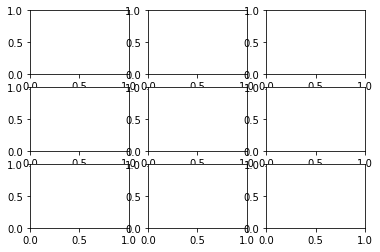